<a href="https://colab.research.google.com/github/xrhd/sandbox/blob/main/1_projects/Unet_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.7973 - loss: 0.2314 - val_accuracy: 0.8131 - val_loss: 0.1191
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8138 - loss: 0.0964 - val_accuracy: 0.8127 - val_loss: 0.0903
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8139 - loss: 0.0894 - val_accuracy: 0.8131 - val_loss: 0.0885
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8139 - loss: 0.0880 - val_accuracy: 0.8130 - val_loss: 0.0878
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8136 - loss: 0.0869 - val_accuracy: 0.8133 - val_loss: 0.0872
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8140 - loss: 0.0860 - val_accuracy: 0.8131 - val_loss: 0.0869
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8142 - loss: 0.0855 - val_accuracy: 0.8134 - val_loss: 0.0866
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

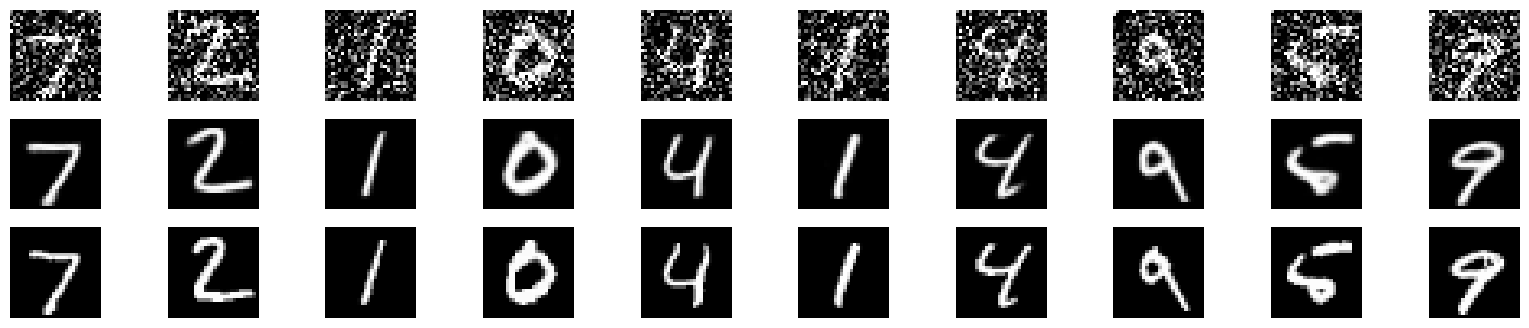

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and prepare the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add random noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# U-Net model definition
def unet(input_size=(28, 28, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model
unet_model = unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet_model.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))

# Denoise the test images
denosed_images = unet_model.predict(x_test_noisy)

# Plot some examples of the noisy and denoised images
def plot_images(noisy, denoised, original, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Noisy images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Denoised images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Original images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Show results
plot_images(x_test_noisy, denosed_images, x_test, n=10)
